# Questions:

- Is there any intuitive reason as to why average gradient at large scales is not 1.5?
- Mostly fine until 2D, from which point on mostly not fine:
  - Unclear exactly what wording in 2d means about find the something and the argument of a function F
  - Unclear whether a simple curve fit is what 2e is asking for, the approximation doesn't seem particularly good
  - Unclear how to make the height distributions undergo "data collapse" in 2f or 2g or what that would even look like for a histogram
  - For question 3 the data seem to be different from figures in lecture notes, with the data collapse not looking as expected

In [2]:
# Python 3.9.14
# Run code formatting with `nbqa autopep8 --in-place oslo.ipynb`
# Can run static type checking with `nbqa mypy oslo.ipynb`, but doesn't play nicely with numpy

from logbin import logbin
import random
import matplotlib.pyplot as plt  # type: ignore
import numpy as np
from time import sleep
from IPython.display import clear_output  # type: ignore
from scipy.optimize import curve_fit  # type: ignore

In [3]:
class Model:
    def __init__(self, length: int) -> None:
        """
        Initialise a new Oslo model of a given length
        """
        # min length of 3
        if length < 3:
            raise Exception("Min length is 3")
        self.length: int = length
        # the number of grains at a given location
        self.heights: list[int] = [0] * length
        # the gradient at a given location
        self.gradients: list[int] = [0] * length
        # generate an empty thresholds list
        self.thresholds: list[int] = [0] * length
        # record that the system is in the transient state
        self.is_transient: bool = True
        # randomise each of the new threshold values
        for i in range(length):
            self.new_threshold(i)
        # set plotting interactive mode on
        plt.ion()

    def get_length(self) -> int:
        return self.length

    def get_heights(self) -> list[int]:
        return self.heights

    def get_gradients(self) -> list[int]:
        return self.gradients

    def get_thresholds(self) -> list[int]:
        return self.thresholds

    def get_pile_height(self) -> int:
        return self.heights[0]

    def get_is_transient(self) -> bool:
        return self.is_transient

    def check_index_in_range(self, i: int) -> None:
        """
        Check the index is within the range of the model.
        If not, raise an exception
        """
        # note z_1 has index 0, z_l has index L-1
        if i >= self.length:
            raise Exception("Index out of range")

    def new_threshold(self, i: int) -> None:
        """
        Set a new threshold at position `i`.
        The threshold will be either 1 or 2 with equal chance.
        """
        self.check_index_in_range(i)
        self.thresholds[i] = random.randint(1, 2)

    def drive(self) -> None:
        """
        Add a single grain to the first position
        """
        self.heights[0] += 1
        self.gradients[0] += 1

    def is_supercritical(self, i: int) -> bool:
        """
        Return whether position `i`` is above the threshold
        """
        self.check_index_in_range(i)
        return self.gradients[i] > self.thresholds[i]

    def relax(self, i: int) -> None:
        """
        Relax the  site `i`, assuming it is above the threshold
        """
        self.check_index_in_range(i)
        if i == 0:
            self.heights[i] -= 1
            self.heights[i+1] += 1
            self.gradients[i] -= 2
            self.gradients[i+1] += 1
        elif i == self.length - 1:
            # end relaxation marks the transition to steady state
            if self.is_transient:
                self.is_transient = False
            self.heights[i] -= 1
            self.gradients[i] -= 1
            self.gradients[i-1] += 1
        else:
            self.heights[i] -= 1
            self.heights[i+1] += 1
            self.gradients[i] -= 2
            self.gradients[i-1] += 1
            self.gradients[i+1] += 1

        # ensure no values are below zero
        if self.heights[i] < 0:
            self.heights[i] = 0
        if self.gradients[i] < 0:
            self.gradients[i] = 0

        self.new_threshold(i)

    def cycle(self) -> None:
        """
        Perform one system cycle of driving and relaxation.
        """
        # add a grain to the first position
        self.drive()
        # relax all positions until stable
        pointer = 0
        while pointer < self.length:
            if self.is_supercritical(pointer):
                self.relax(pointer)
                pointer -= 1
                if pointer < 0:
                    pointer = 0
            else:
                pointer += 1

    def cycle_with_relax_count(self) -> int:
        """
        Perform one system cycle of driving and relaxation and return the number of relaxations.
        """
        # add a grain to the first position
        self.drive()
        # relax all positions until stable
        pointer = 0
        counter = 0
        while pointer < self.length:
            if self.is_supercritical(pointer):
                self.relax(pointer)
                counter += 1
                pointer -= 1
                if pointer < 0:
                    pointer = 0
            else:
                pointer += 1
        return counter

    def plot(self, sleep_amount=0, clear_screen=True) -> None:
        """
        Show the current state of the system in a graphic
        """
        sleep(sleep_amount)
        if clear_screen:
            clear_output()
        f = plt.figure()
        f.set_figwidth(3)
        f.set_figheight(6)
        plt.bar(np.array(range(self.length)) + 1, self.heights, width=0.95)
        plt.axis('scaled')
        plt.yticks(range(self.length * 2))
        plt.xticks(np.array(range(self.length)) + 1)
        plt.grid(axis='y')
        plt.show()

### Testing the logic using plotting

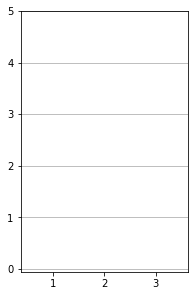

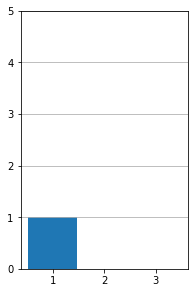

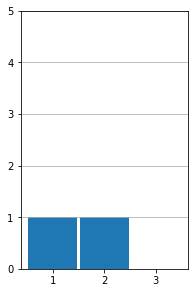

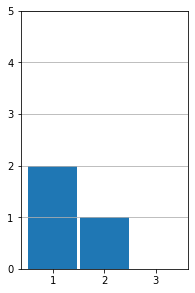

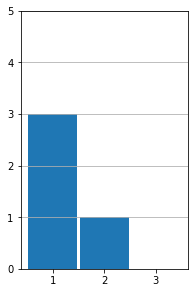

In [4]:
test_model = Model(3)

for i in range(5):
    test_model.plot(clear_screen=False)
    test_model.cycle()

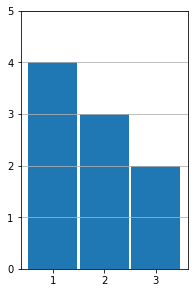

In [6]:
# a quick and easy animation implementation
sleep_amount = 0.5

test_model = Model(3)

for i in range(10):
    test_model.plot(sleep_amount)
    test_model.cycle()

### Testing the logic

Add some more simple tests in here later on

In [7]:
# measuring transient phase for L16
test_model = Model(16)
counter = 0
while test_model.get_is_transient():
    test_model.cycle()
    counter += 1
print(counter)

207


In [8]:
# measuring transient phase for L32
test_model = Model(32)
counter = 0
while test_model.get_is_transient():
    test_model.cycle()
    counter += 1
print(counter)

881


In [9]:
# L16 model should have average height of 26.5

final_heights = []

test_model = Model(16)
# get to steady state
while test_model.get_is_transient():
    test_model.cycle()
# once in steady state run for a set number of trials
for i in range(100000):
    test_model.cycle()
    final_heights.append(test_model.get_pile_height())

print("Expected: 26.5, measured: %.2f" % np.average(final_heights))

Expected: 26.5, measured: 26.53


In [10]:
# L32 model should have average height of 53.9

final_heights = []

test_model = Model(32)
# get to steady state
while test_model.get_is_transient():
    test_model.cycle()
# once in steady state run for a set number of trials
for i in range(10000):
    test_model.cycle()
    final_heights.append(test_model.get_pile_height())

print("Expected: 53.9, measured: %.2f" % np.average(final_heights))

Expected: 53.9, measured: 53.85


### 2a) Height of the Pile

In [11]:
# measuring transient phase for L256, seems to be 50-60k cycles
test_model = Model(256)
counter = 0
while test_model.get_is_transient():
    test_model.cycle()
    counter += 1
print(counter)

55976


In [12]:
heights: list[list[int]] = []
lengths = [4, 8, 16, 32, 64, 128, 256]
number_cycles = 80000

In [13]:
for length in lengths:
    output = []
    model = Model(length)
    for i in range(number_cycles):
        model.cycle()
        output.append(model.get_pile_height())
    heights.append(output)
    print(length, 'complete')

4 complete
8 complete
16 complete
32 complete
64 complete
128 complete
256 complete


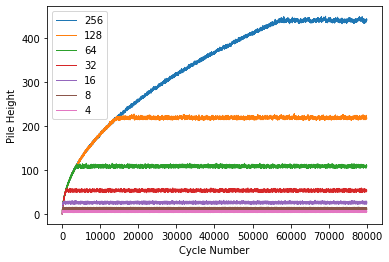

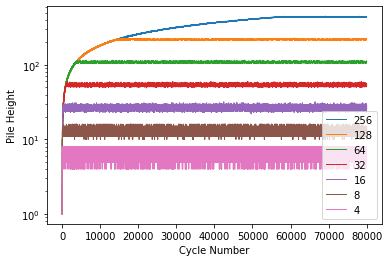

In [18]:
# linear plot
for i in reversed(range(len(lengths))):
    plt.plot(range(number_cycles), heights[i], label=str(
        lengths[i]), linewidth=1)
plt.legend()
plt.xlabel("Cycle Number")
plt.ylabel("Pile Height")
plt.show()

# log linear plot
for i in reversed(range(len(lengths))):
    plt.plot(range(number_cycles), heights[i], label=str(
        lengths[i]), linewidth=1)
plt.legend()
plt.xlabel("Cycle Number")
plt.ylabel("Pile Height")
plt.yscale("log")
plt.show()

### 2b) Cross Over Times

In [24]:
cross_over_times = []
lengths = [4, 8, 16, 32, 64, 128, 256]
repetitions = 10

In [25]:
for length in lengths:
    times = []
    for i in range(repetitions):
        model = Model(length)
        # if a grain exits on the first cycle, counter should be 0
        # since we are measuring total grains *before* an exit
        counter = -1 
        while model.get_is_transient():
            model.cycle()
            counter += 1
        times.append(counter)
    cross_over_times.append(np.average(times))
    print(length, 'complete')

4 complete
8 complete
16 complete
32 complete
64 complete
128 complete
256 complete


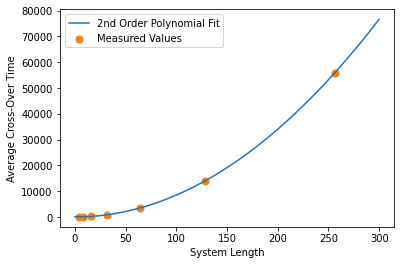

In [26]:
# investigate whether the data scale with L**2
poly_fit = np.polyfit(lengths, cross_over_times, 2)
fit_x_vals = np.linspace(0, 300, 100)
fit_y_vals = np.poly1d(poly_fit)(fit_x_vals)
plt.plot(fit_x_vals, fit_y_vals, label='2nd Order Polynomial Fit')

plt.scatter(lengths, cross_over_times, s=50,
            marker="o", c="C1", label="Measured Values")
plt.legend()
plt.xlabel("System Length")
plt.ylabel("Average Cross-Over Time")
plt.show()

### 2c) Scaling Arguments

For a system length far larger than 1, there will be some consistent value for the average gradient. This is not necessarily the average of the two possible threshold gradients since a gradient can be changed by grains falling onto it, grains leaving it as well as the critical threshold value.

In [27]:
averages = []

for i in range(100):
    model = Model(64)
    while model.is_transient:
        model.cycle()
    for i in range(10000):
        model.cycle
    averages.append(np.average(model.gradients))

print(np.average(averages))

1.64015625


Empirically the average value is found to be about 1.65, however all that matters is that this average gradient is scale independent on large scales. Given a set gradient, this gives large systems beyond the cross over point a triangular form, with angles that do not change with scale for all sufficiently large numbers. 

This gives the height of the triangle to be directly proportional to the base of the triangle, i.e. the length of the system. Similarly, cross over time corresponds to the area of the triangle, and thus cross over time should scale with square of the system length.

### 2d) Data Collapse of Average Height Scaling

Confused about what it's asking us to do here. Data already collapses onto a straight line for steady state, so unsure what the "function", "something" and "argument" are, and thus not sure what to do for evaluating the function as the argument gets very large and very small. 

In [17]:
average_heights = []
lengths = [4, 8, 16, 32, 64, 128, 256]
repetitions = 20

In [18]:
for length in lengths:
    height_values: list[int] = []
    for i in range(repetitions):
        model = Model(length)
        while model.get_is_transient():
            model.cycle()
        for i in range(5000):
            model.cycle()
        height_values.append(model.get_pile_height())
    average_heights.append(np.average(height_values))
    print(length, 'complete')

4 complete
8 complete
16 complete
32 complete
64 complete
128 complete
256 complete


In [19]:
average_heights

[6.4, 12.85, 26.55, 53.45, 109.0, 219.3, 440.05]

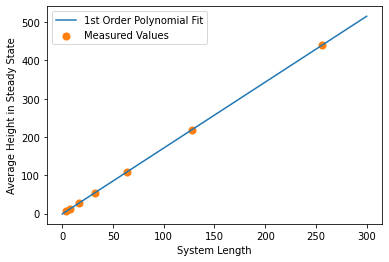

In [20]:
poly_fit = np.polyfit(lengths, average_heights, 1)
fit_x_vals = np.linspace(0, 300, 100)
fit_y_vals = np.poly1d(poly_fit)(fit_x_vals)
plt.plot(fit_x_vals, fit_y_vals, label='1st Order Polynomial Fit')

plt.scatter(lengths, average_heights, s=50, marker="o",
            c="C1", label="Measured Values")
plt.legend()
plt.xlabel("System Length")
plt.ylabel("Average Height in Steady State")
plt.show()

#### Height scaling during the transient

This is predicted to be proportional to time to the power 1/2, since time corresponds to area, and height scales with the square root of area.

In [21]:
average_height_sequences = []
lengths = [4, 8, 16, 32, 64, 128, 256]
repetitions = 5

In [22]:
# a function to average lists of different lengths
# all lists are truncated to the shortest length

def average_different_lengths(a: list[list[int]]) -> list[int]:
    list_lengths = [len(i) for i in a]
    min_length = min(list_lengths)
    for l in a:
        while len(l) > min_length:
            l.pop(-1)
    return list(np.average(a, axis=0))

In [23]:
for length in lengths:
    heights = []
    for i in range(repetitions):
        model = Model(length)
        values = []
        while model.get_is_transient():
            model.cycle()
            values.append(model.get_pile_height())
        heights.append(values)
    average_height_sequences.append(average_different_lengths(heights))
    print(length, 'complete')

4 complete
8 complete
16 complete
32 complete
64 complete
128 complete
256 complete


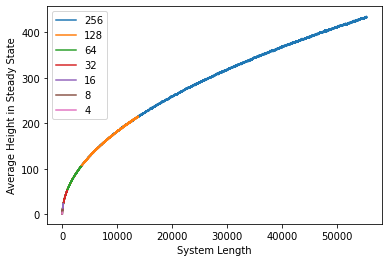

In [24]:
# linear plot
for i in reversed(range(len(lengths))):
    plt.plot(range(len(average_height_sequences[i])),
             average_height_sequences[i], label=str(lengths[i]))
plt.legend()
plt.xlabel("System Length")
plt.ylabel("Average Height in Steady State")
plt.show()

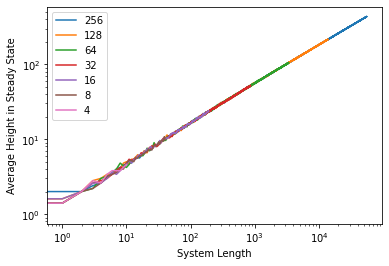

In [25]:
# log-log plot
for i in reversed(range(len(lengths))):
    plt.plot(range(len(average_height_sequences[i])),
             average_height_sequences[i], label=str(lengths[i]))
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.xlabel("System Length")
plt.ylabel("Average Height in Steady State")
plt.show()

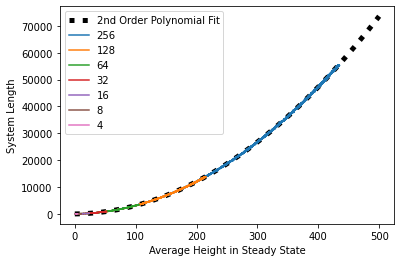

In [26]:
# if following a power law to the 1/2, then flipping the axis will follow a second order polynomial fit

# fitting the 256 data
poly_fit = np.polyfit(
    average_height_sequences[-1], range(len(average_height_sequences[-1])), 2)
fit_x_vals = np.linspace(0, 500, 100)
fit_y_vals = np.poly1d(poly_fit)(fit_x_vals)
plt.plot(fit_x_vals, fit_y_vals, label='2nd Order Polynomial Fit',
         linestyle='dotted', c='k', linewidth=5)

# linear plot
for i in reversed(range(len(lengths))):
    plt.plot(average_height_sequences[i], range(
        len(average_height_sequences[i])), label=str(lengths[i]))
plt.legend()
plt.xlabel("Average Height in Steady State")
plt.ylabel("System Length")
plt.show()

### 2e) Scaling Corrections to Height

In [27]:
height_sequence_list: list[list[int]] = []
lengths = [4, 8, 16, 32, 64, 128, 256]
num_cycles = 10000

In [28]:
for length in lengths:
    height_sequence: list[int] = []
    model = Model(length)
    while model.get_is_transient():
        model.cycle()
    for i in range(num_cycles):
        model.cycle()
        height_sequence.append(model.get_pile_height())
    height_sequence_list.append(height_sequence)
    print(length, 'complete')

4 complete
8 complete
16 complete
32 complete
64 complete
128 complete
256 complete


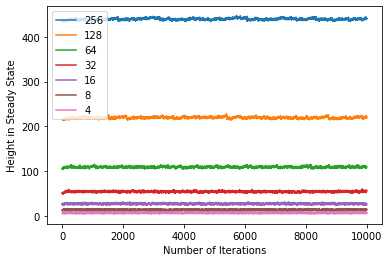

In [29]:
# linear plot of the raw data
for i in reversed(range(len(lengths))):
    plt.plot(range(len(height_sequence_list[i])),
             height_sequence_list[i], label=str(lengths[i]))
plt.legend()
plt.xlabel("Number of Iterations")
plt.ylabel("Height in Steady State")
plt.show()

In [30]:
# counting frequencies to check the histograms
counts: dict[int, int] = {}
for i in np.sort(height_sequence_list[0]):
    try:
        counts[i] += 1
    except:
        counts[i] = 1
counts

{4: 52, 5: 1441, 6: 4551, 7: 3306, 8: 650}

Length: 4
Average: 6.3061
Std: 0.814
Probability distribution:


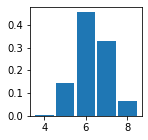

Length: 8
Average: 12.9657
Std: 0.956
Probability distribution:


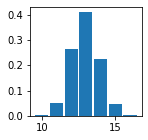

Length: 16
Average: 26.5517
Std: 1.132
Probability distribution:


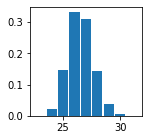

Length: 32
Average: 53.7866
Std: 1.339
Probability distribution:


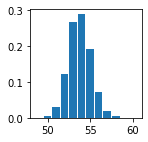

Length: 64
Average: 108.7493
Std: 1.574
Probability distribution:


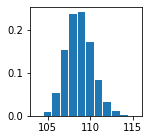

Length: 128
Average: 219.1665
Std: 1.859
Probability distribution:


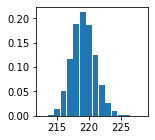

Length: 256
Average: 439.4682
Std: 2.027
Probability distribution:


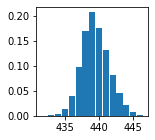

In [31]:
for i in range(len(lengths)):
    data = height_sequence_list[i]
    print("="*10)
    print("Length:", lengths[i])
    average = np.average(data)
    print("Average:", average)
    std = np.std(data)
    print("Std:", "%.3f" % std)
    print("Probability distribution:")
    plt.subplots(figsize=(2, 2))
    plt.hist(data, max(data) - min(data) + 1, density=True,
             rwidth=0.9, range=(min(data)-0.5, max(data)+0.5))
    plt.show()

Assuming the corrections to scaling are of the form given in the instructions:

$\langle h (t;L) \rangle_t = a_0 L (1 - a_1 L^{- \omega_1})$

since we are ignoring higher order terms.

If we fit a first order polynomial to the data, we should get a value for a_0:

In [32]:
average_height_list: list = []
for l in height_sequence_list:
    average_height_list.append(np.average(l))
print(average_height_list)

[6.3061, 12.9657, 26.5517, 53.7866, 108.7493, 219.1665, 439.4682]


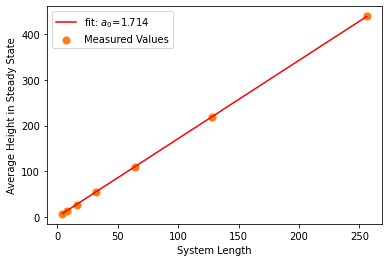

In [50]:
# fitting just a0 L, neglecting further terms
def linear_func(x, a0):
    return a0 * x


popt, pcov = curve_fit(linear_func, lengths, average_height_list)
plt.plot(lengths, linear_func(lengths, popt),
         'r-', label="fit: $a_0$=%.3f" % popt)

plt.scatter(lengths, average_height_list, s=50, marker="o",
            c="C1", label="Measured Values")
plt.legend()
plt.xlabel("System Length")
plt.ylabel("Average Height in Steady State")
plt.show()

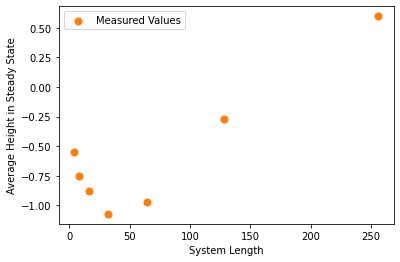

In [51]:
# taking the residual from the linear fit
residual_y_vals: list[int] = []
for i in range(len(average_height_list)):
    residual_y_vals.append(average_height_list[i] - popt * lengths[i])

plt.scatter(lengths, residual_y_vals, s=50, marker="o",
            c="C1", label="Measured Values")
plt.legend()
plt.xlabel("System Length")
plt.ylabel("Average Height in Steady State")
plt.show()

/var/folders/4c/jqcncstx7v9ccg0y_h0sbdy00000gn/T/ipykernel_29118/3306233108.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  return a0 * x * (1 - a1 * (x ** - o1))
/var/folders/4c/jqcncstx7v9ccg0y_h0sbdy00000gn/T/ipykernel_29118/3306233108.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return a0 * x * (1 - a1 * (x ** - o1))


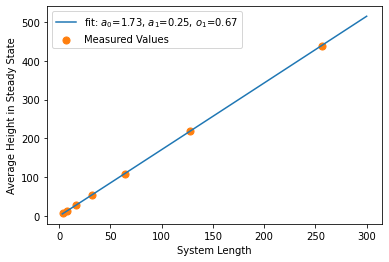

In [47]:
# fitting the entire function, including omega 1 term
def full_fit_func(x, a0, a1, o1):
    return a0 * x * (1 - a1 * (x ** - o1))


popt, pcov = curve_fit(full_fit_func, lengths, average_height_list)
x_vals = np.linspace(0, 300, 100)
y_vals = [full_fit_func(i, *popt) for i in x_vals]
plt.plot(x_vals, y_vals, label="fit: $a_0$=%.2f, $a_1$=%.2f, $o_1$=%.2f" %
         (popt[0], popt[1], popt[2]))


plt.scatter(lengths, average_height_list, s=50, marker="o",
            c="C1", label="Measured Values")
plt.legend()
plt.xlabel("System Length")
plt.ylabel("Average Height in Steady State")
plt.show()

### 2f) Standard Deviation Scaling 

How does standard deviation scale with system length

In [52]:
std_values = [np.std(data) for data in height_sequence_list]

In [53]:
std_values

[0.8135126243642444,
 0.9556796063535101,
 1.1323105183649933,
 1.3387533155887983,
 1.5744362514881318,
 1.858810842985375,
 2.026620033454717]

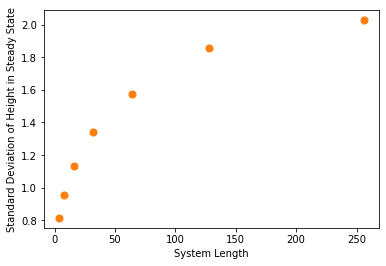

In [54]:
plt.scatter(lengths, std_values, s=50, marker="o",
            c="C1")
plt.xlabel("System Length")
plt.ylabel("Standard Deviation of Height in Steady State")
plt.show()

We might expect the std to scale with the average value, and if we take the average to have scaled as 

$a_0 L (1 - a_1 L^{- \omega_1})$

then we might try fitting this curve to the standard deviation also:

/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/4c/jqcncstx7v9ccg0y_h0sbdy00000gn/T/ipykernel_29118/246230816.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return a0 * x * (1 - a1 * (x ** - o1))
/var/folders/4c/jqcncstx7v9ccg0y_h0sbdy00000gn/T/ipykernel_29118/246230816.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return a0 * x * (1 - a1 * (x ** - o1))


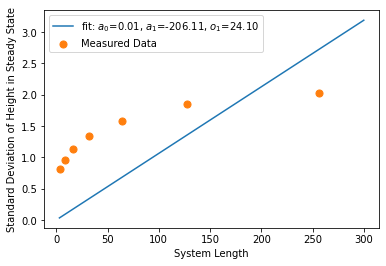

In [70]:
def full_func_copy(x, a0, a1, o1):
    return a0 * x * (1 - a1 * (x ** - o1))


popt, pcov = curve_fit(full_func_copy, lengths, std_values)
x_vals = np.linspace(0, 300, 100)
y_vals = [full_func_copy(i, *popt) for i in x_vals]
plt.plot(x_vals, y_vals, label="fit: $a_0$=%.2f, $a_1$=%.2f, $o_1$=%.2f" %
         (popt[0], popt[1], popt[2]))

plt.scatter(lengths, std_values, s=50, marker="o",
            c="C1", label="Measured Data")
plt.xlabel("System Length")
plt.legend()
plt.ylabel("Standard Deviation of Height in Steady State")
plt.show()

However this doesn't seem to work very well. 

Given I haven't fully understood the previous problem, I don't think it's worth me spending much more time on this, however the graph does scale a little better with a fitted square root function.

/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


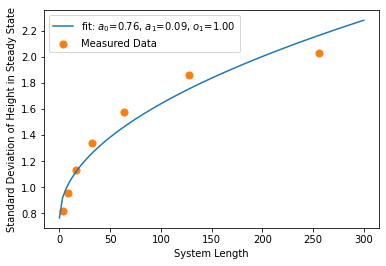

In [71]:
def fitting_func(x, a0, a1, o1):
    return a0 + a1 * (x ** 0.5)


popt, pcov = curve_fit(fitting_func, lengths, std_values)
x_vals = np.linspace(0, 300, 100)
y_vals = [fitting_func(i, *popt) for i in x_vals]
plt.plot(x_vals, y_vals, label="fit: $a_0$=%.2f, $a_1$=%.2f, $o_1$=%.2f" %
         (popt[0], popt[1], popt[2]))

plt.scatter(lengths, std_values, s=50, marker="o",
            c="C1", label="Measured Data")
plt.xlabel("System Length")
plt.legend()
plt.ylabel("Standard Deviation of Height in Steady State")
plt.show()

### 2g) The Height Probability Distribution

i) if each gradient was independent of every other gradient then by the central limit theorem, we would expect the height probability distribution to be a symmetrical Gaussian about the average. Increasing the system size would both increase in the average, implying the distribution would also increase in width, but by the central limit theorem we would expect a decrease in width since there are more independent variables in the system. Unclear which, if either, of these effects would dominate.

ii) plotting all of the height probability distributions onto one graph, subtracting the respective mean height from each:

Length: 4
Average: 6.3061
Std: 0.814
Probability distribution:


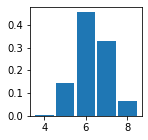

Length: 8
Average: 12.9657
Std: 0.956
Probability distribution:


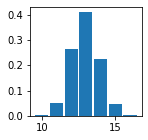

Length: 16
Average: 26.5517
Std: 1.132
Probability distribution:


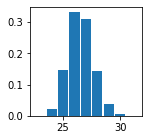

Length: 32
Average: 53.7866
Std: 1.339
Probability distribution:


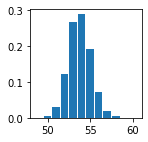

Length: 64
Average: 108.7493
Std: 1.574
Probability distribution:


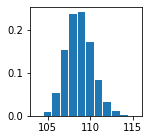

Length: 128
Average: 219.1665
Std: 1.859
Probability distribution:


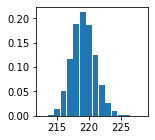

Length: 256
Average: 439.4682
Std: 2.027
Probability distribution:


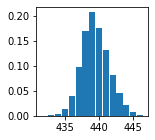

In [84]:
for i in range(len(lengths)):
    data = height_sequence_list[i]
    print("="*10)
    print("Length:", lengths[i])
    average = np.average(data)
    print("Average:", average)
    std = np.std(data)
    print("Std:", "%.3f" % std)
    print("Probability distribution:")
    plt.subplots(figsize=(2, 2))
    plt.hist(data, max(data) - min(data) + 1, density=True,
             rwidth=0.9, range=(min(data)-0.5, max(data)+0.5))
    plt.show()

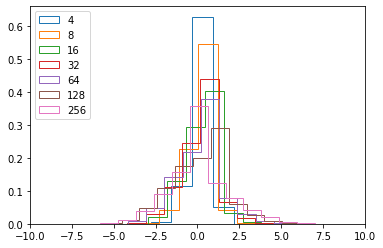

Same data shown in a filled bar graph:


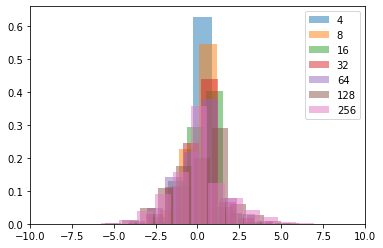

In [104]:
for i in range(len(lengths)):
    data = height_sequence_list[i]
    average = np.average(data)
    centred_data = [height-average for height in data]
    plt.hist(centred_data, max(data) - min(data), density=True, label=lengths[i], range=(
        min(centred_data)-0.5, max(centred_data)+0.5), rwidth=0.9, color="C%s" % i, histtype='step')
plt.legend()
plt.xlim(-10, 10)
plt.show()

print("Same data shown in a filled bar graph:")

for i in range(len(lengths)):
    data = height_sequence_list[i]
    average = np.average(data)
    centred_data = [height-average for height in data]
    plt.hist(centred_data, max(data) - min(data), density=True, label=lengths[i], alpha=0.5, range=(
        min(centred_data)-0.5, max(centred_data)+0.5), rwidth=0.9, color="C%s" % i)
plt.legend()
plt.xlim(-10, 10)
plt.show()

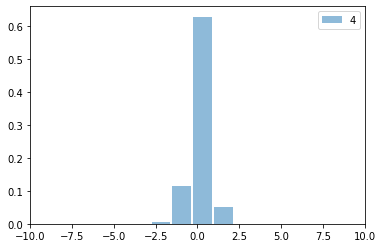

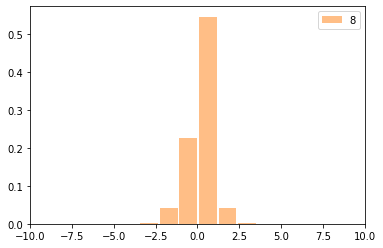

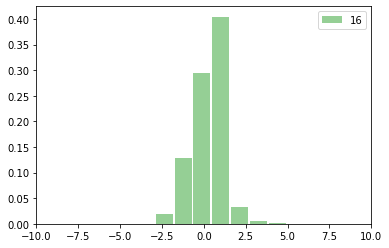

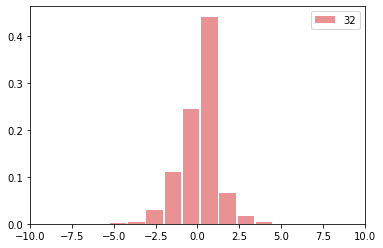

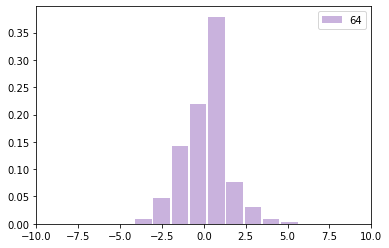

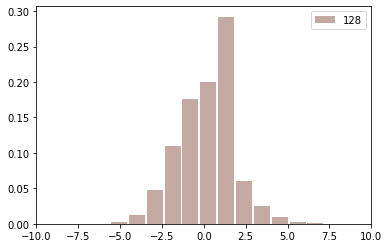

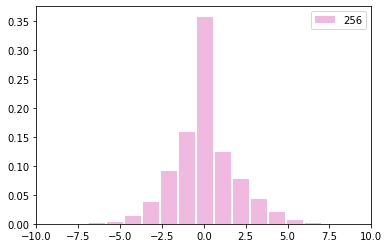

In [99]:
# showing the same information on separate graphs for convenience
for i in range(len(lengths)):
    data = height_sequence_list[i]
    average = np.average(data)
    centred_data = [height-average for height in data]
    plt.hist(centred_data, max(data) - min(data), density=True, label=lengths[i], alpha=0.5, range=(
        min(centred_data)-0.5, max(centred_data)+0.5), rwidth=0.9, color="C%s" % i)
    plt.legend()
    plt.xlim(-10, 10)
    plt.show()

Unsure for the rest of 2g, since I am unsure how to achieve the data collapse. 

For the numerical test as to whether the gradients are indeed statistically independent, is finding the average gradient sufficient? If they were independent, we would expect this value to be 1.5, however it was found to be over 1.6, indicating that they are not independent.

### 3) Avalanches

In [137]:
avalanches_list: list[list[int]] = []
lengths = [4, 8, 16, 32, 64, 128, 256]
num_cycles = 100000

In [138]:
for length in lengths:
    model = Model(length)
    avalanches: list[int] = []
    # get the model to steady state
    while model.get_is_transient():
        model.cycle()
    # only then count the avalanches
    for i in range(num_cycles):
        avalanches.append(model.cycle_with_relax_count())
    avalanches_list.append(avalanches)
    print(length, 'complete')

4 complete
8 complete
16 complete
32 complete
64 complete
128 complete
256 complete


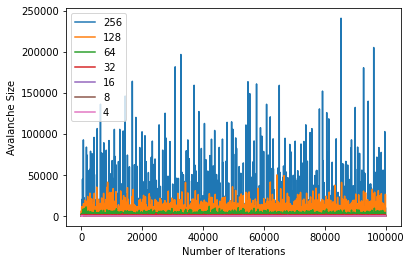

In [139]:
# linear plot of the raw data
for i in reversed(range(len(lengths))):
    plt.plot(range(len(avalanches_list[i])),
             avalanches_list[i], label=str(lengths[i]))
plt.legend()
plt.xlabel("Number of Iterations")
plt.ylabel("Avalanche Size")
plt.show()

In [140]:
# checking that the "avalanche size 0" cycles are being recorded
counts = {}
for i in np.sort(avalanches_list[0]):
    try:
        counts[i] += 1
    except:
        counts[i] = 1
counts[0]

35969

In [141]:
# calculate the probabilities manually
probs_list = []

for l in range(len(lengths)):
    probs = {}
    for i in np.sort(avalanches_list[l]):
        try:
            probs[i] += 1/num_cycles
        except:
            probs[i] = 1/num_cycles
    probs_list.append(probs)

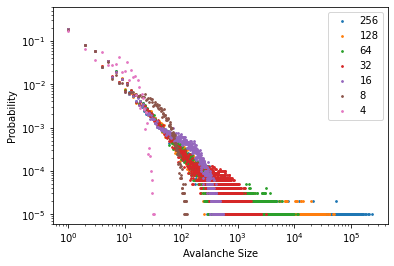

In [154]:
# plotting the manual probability values
for l in reversed(range(len(lengths))):
    plt.scatter(probs_list[l].keys(),
                probs_list[l].values(), s=3, label=str(lengths[l]))
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Avalanche Size')
plt.ylabel('Probability')
plt.show()

In [146]:
# using the log binning function

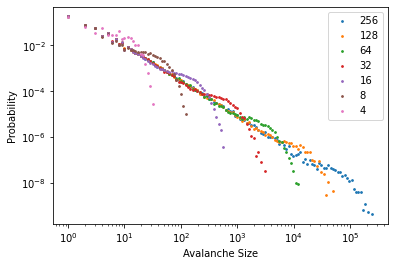

In [166]:
# note I went for a scale of 1.1, since that looked the best and is also used in the lecture notes in the data collapse section
for l in reversed(range(len(lengths))):
    log_probs = logbin(avalanches_list[l], scale=1.1, zeros=False)
    plt.scatter(log_probs[0], log_probs[1], s=3, label=str(lengths[l]))
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Avalanche Size')
plt.ylabel('Probability')
plt.show()

This does not seem to be as good a data collapse as expected, as each successive system length seems to have it's own deviation from the main data collapse.

Comparing with the notes, the main line seems to be correct and goes over the correct ranges in both dimensions. 

Given this, I haven't attempted to find the variables in part 3a part ii yet.

### 3b) Avalanche Moments

In [169]:
def calculate_moment(data, order):
    scaled_data = [i**order for i in data]
    return sum(scaled_data) / len(data)


moments = [1, 2, 3, 4]

In [175]:
for m in moments:
    for l in range(len(lengths)):
        moment = calculate_moment(avalanches_list[l], m)
        print("Length: %3d, Order: %d, Moment: %.1f" % (lengths[l], m, moment))

Length:   4, Order: 1, Moment: 4.0
Length:   8, Order: 1, Moment: 8.0
Length:  16, Order: 1, Moment: 16.0
Length:  32, Order: 1, Moment: 32.0
Length:  64, Order: 1, Moment: 64.0
Length: 128, Order: 1, Moment: 127.9
Length: 256, Order: 1, Moment: 255.6
Length:   4, Order: 2, Moment: 44.7
Length:   8, Order: 2, Moment: 304.5
Length:  16, Order: 2, Moment: 2366.8
Length:  32, Order: 2, Moment: 20115.3
Length:  64, Order: 2, Moment: 177371.5
Length: 128, Order: 2, Moment: 1644789.6
Length: 256, Order: 2, Moment: 16037991.7
Length:   4, Order: 3, Moment: 642.7
Length:   8, Order: 3, Moment: 16312.5
Length:  16, Order: 3, Moment: 527113.4
Length:  32, Order: 3, Moment: 20152057.1
Length:  64, Order: 3, Moment: 800839128.8
Length: 128, Order: 3, Moment: 34940465261.7
Length: 256, Order: 3, Moment: 1704091463390.5
Length:   4, Order: 4, Moment: 10628.2
Length:   8, Order: 4, Moment: 1034311.6
Length:  16, Order: 4, Moment: 142008841.8
Length:  32, Order: 4, Moment: 25323571048.8
Length:  64, O

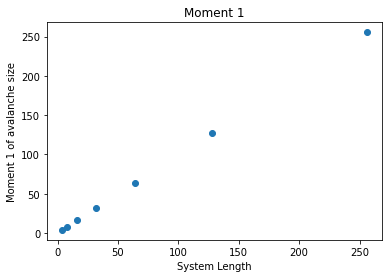

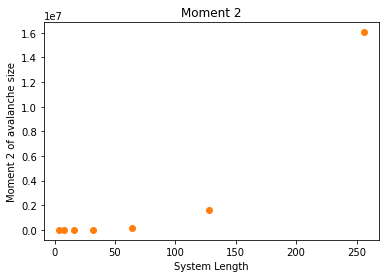

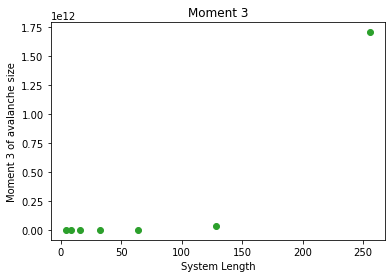

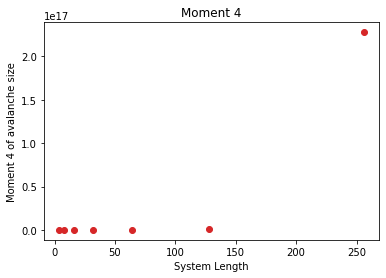

In [179]:
# plotting
for m in moments:
    y_vals = []
    for l in range(len(lengths)):
        y_vals.append(calculate_moment(avalanches_list[l], m))

    plt.scatter(lengths, y_vals, c="C%s" % (m-1))
    plt.xlabel("System Length")
    plt.ylabel("Moment %s of avalanche size" % m)
    plt.title("Moment %s" % m)
    plt.show()

Can't complete the finite scaling ansatz question since I didn't complete part i). Will return to this afterwards.